# 워드 클라우드
1. 긍정, 부정으로 라벨링된 댓글들은 단어의 분포가 다를 것이다.

2. 포지션마다 단어의 분포가 다를 것이다.

위의 가설들을 WordCloud를 통해 검증해보자.

In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

In [3]:
!pip install konlpy

In [ ]:
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

In [41]:
import pandas as pd
import numpy as np
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from collections import Counter
from wordcloud import WordCloud

In [2]:
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname = path, size = 10).get_name()
plt.rc('font', family = font_name)
fm._rebuild()

Text(0.5, 1.0, '안녕')

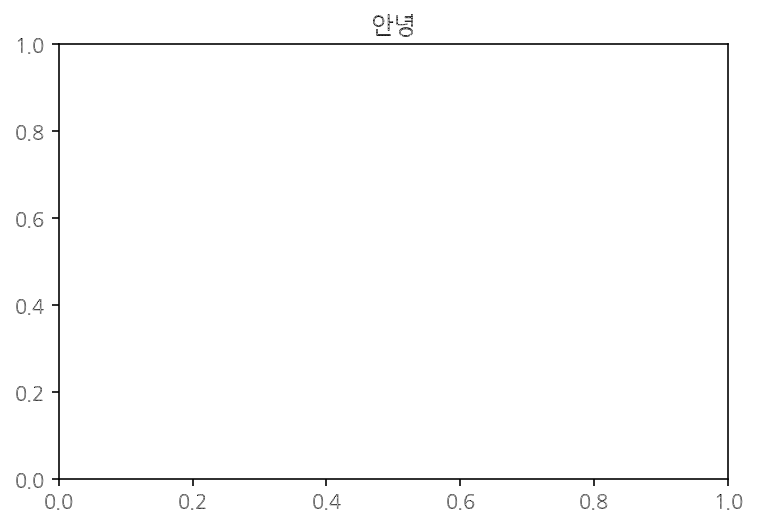

In [3]:
#한글 확인
%config InlineBackend.figure_format = 'retina'
plt.title('안녕')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATA_PATH = '/content/drive/...../'

In [42]:
df = pd.read_csv(f'{DATA_PATH}sentiment_scores.csv')
df.tail()

,userId,player_name,position,comment,rating,score
199876,클롭광팬,박지수,df,선수체감 자체가 엄청 가볍고 민첩함,4.00,1
199877,클롭광팬,박지수,df,주력이랑 방향전환 모두 빨라가지고 수비커버 범위도 넓게 가져갈수 있음.,4.00,0
199878,클롭광팬,박지수,df,5카 기준 2천만bp 정도로 대장급 공격수들을 스피드로 제압가능.. 우리집 센터백은...,4.00,-1
199879,레알의라장군,카르바할,df,좋기만한데....,4.04,0
199880,자기엘카,조 고메스,df,단점 헤딩 실존이랑 똑같음,3.83,0


,userId,player_name,position,comment,rating,score,label
199876,클롭광팬,박지수,df,선수체감 자체가 엄청 가볍고 민첩함,4.00,1,1
199877,클롭광팬,박지수,df,주력이랑 방향전환 모두 빨라가지고 수비커버 범위도 넓게 가져갈수 있음.,4.00,0,0
199878,클롭광팬,박지수,df,5카 기준 2천만bp 정도로 대장급 공격수들을 스피드로 제압가능.. 우리집 센터백은...,4.00,-1,0
199879,레알의라장군,카르바할,df,좋기만한데....,4.04,0,0
199880,자기엘카,조 고메스,df,단점 헤딩 실존이랑 똑같음,3.83,0,0


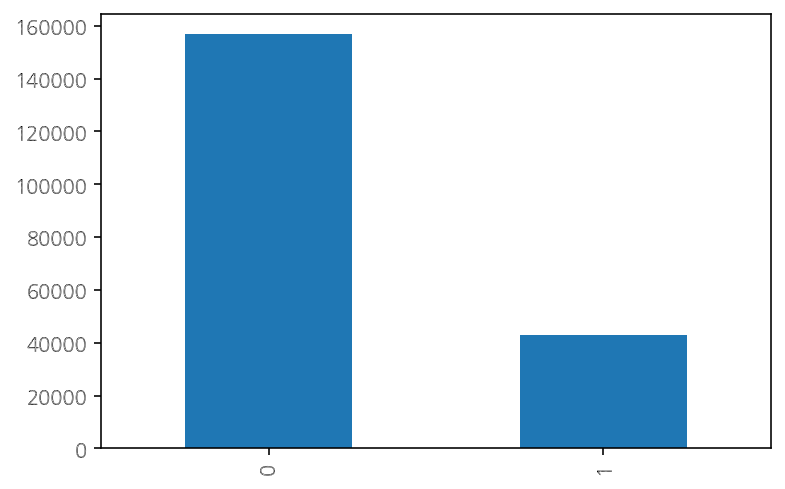

In [43]:
#0보다 크면 긍정(1), 같거나 작으면 부정(0)
df.loc[df.score > 0, 'label'] = 1
df.loc[df.score <= 0, 'label'] = 0
df.label = df.label.astype(int)
display(df.tail())
df.label.value_counts().plot(kind = 'bar')

In [44]:
#감성분석에 필요한 comment와 label만 남겨두기
df = df[['position','comment', 'label']]
df.tail()

,position,comment,label
199876,df,선수체감 자체가 엄청 가볍고 민첩함,1
199877,df,주력이랑 방향전환 모두 빨라가지고 수비커버 범위도 넓게 가져갈수 있음.,0
199878,df,5카 기준 2천만bp 정도로 대장급 공격수들을 스피드로 제압가능.. 우리집 센터백은...,0
199879,df,좋기만한데....,0
199880,df,단점 헤딩 실존이랑 똑같음,0


In [45]:
print(df.duplicated().sum())
print(df.isnull().sum().sum())

4168
0


In [46]:
#중복제거
df.drop_duplicates(inplace = True)
print(df.duplicated().sum())
df.shape

0


(195713, 3)

In [47]:
#숫자, 알파벳, 한글, .외에는 모두 제거
df['comment'] = df['comment'].str.replace('[^0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣 ]','')
df.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,position,comment,label
199876,df,선수체감 자체가 엄청 가볍고 민첩함,1
199877,df,주력이랑 방향전환 모두 빨라가지고 수비커버 범위도 넓게 가져갈수 있음,0
199878,df,5카 기준 2천만bp 정도로 대장급 공격수들을 스피드로 제압가능 우리집 센터백은 굼...,0
199879,df,좋기만한데,0
199880,df,단점 헤딩 실존이랑 똑같음,0


In [48]:
print(df.isnull().sum().sum())
print(df.isnull().sum().sum())
print(df.duplicated(subset = 'comment').sum())
print(df.duplicated(subset = 'comment').sum())

0
0
2200
2200


In [49]:
#중복 확인 및 제거
df.drop_duplicates(subset = 'comment',inplace = True)
print(df.duplicated().sum())

0


In [50]:
df.shape

(193513, 3)

In [97]:
# 불용어 사전
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', 
             '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '구매합니다', '올렸습니다',
             '팔렸나요', '팔아주신분', '얼만가요', '판매합니다']

In [ ]:
new_stopwords = stopwords + ['판매', '완료', 'ㅋㅋㅋ', 'ㅋㅋ', '습니다', '는데', '으로', '에서', '지만']

In [119]:
mecab = Mecab()

# 토큰화, 불용어 제거
df['tokenized'] = df['comment'].apply(mecab.morphs)
df['tokenized'] = df['tokenized'].apply(lambda x: [item for item in x if item not in new_stopwords and len(item) >= 2])
df.tail()

,position,comment,label,tokenized
199876,df,선수체감 자체가 엄청 가볍고 민첩함,1,"[선수, 체감, 자체, 엄청, 가볍, 민첩]"
199877,df,주력이랑 방향전환 모두 빨라가지고 수비커버 범위도 넓게 가져갈수 있음,0,"[주력, 이랑, 방향, 전환, 모두, 빨라, 가지, 수비, 커버, 범위, 가져갈]"
199878,df,5카 기준 2천만bp 정도로 대장급 공격수들을 스피드로 제압가능 우리집 센터백은 굼...,0,"[기준, 천만, bp, 정도, 대장, 공격수, 스피드, 제압, 가능, 우리, 센터,..."
199879,df,좋기만한데,0,[한데]
199880,df,단점 헤딩 실존이랑 똑같음,0,"[단점, 헤딩, 실존, 이랑, 똑같]"


In [157]:
# tokenized 변수를 csv로 저장하면 다시 불러올 때 리스트 형식이 아니라 string 형식으로 데이터가 저장되어있다.
# 하지만, 피클 형식으로 저장하면 그대로 리스트 형식으로 데이터 타입을 유지시킬 수 있다.

#df.to_pickle(f"{DATA_PATH}df_tokenized.pkl")
# df = pd.read_pickle(f"{DATA_PATH}df_tokenized.pkl")
# df.tail()

,position,comment,label,tokenized
199876,df,선수체감 자체가 엄청 가볍고 민첩함,1,"[선수, 체감, 자체, 엄청, 가볍, 민첩]"
199877,df,주력이랑 방향전환 모두 빨라가지고 수비커버 범위도 넓게 가져갈수 있음,0,"[주력, 이랑, 방향, 전환, 모두, 빨라, 가지, 수비, 커버, 범위, 가져갈]"
199878,df,5카 기준 2천만bp 정도로 대장급 공격수들을 스피드로 제압가능 우리집 센터백은 굼...,0,"[기준, 천만, bp, 정도, 대장, 공격수, 스피드, 제압, 가능, 우리, 센터,..."
199879,df,좋기만한데,0,[한데]
199880,df,단점 헤딩 실존이랑 똑같음,0,"[단점, 헤딩, 실존, 이랑, 똑같]"


In [120]:
#긍정과 부정 단어는 어떤 단어들이 많이 나올까
negative_words = np.hstack(df[df.label == 0]['tokenized'].values)
positive_words = np.hstack(df[df.label == 1]['tokenized'].values)

In [121]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(10))

[('진짜', 16629), ('그냥', 12512), ('급여', 12323), ('인데', 11323), ('체감', 10933), ('패스', 10443), ('보다', 10316), ('아니', 10217), ('선수', 9579), ('침투', 9564)]


In [128]:
#포지션별 단어수
fw_words = np.hstack(df[df.position == 'fw']['tokenized'].values)
mf_words = np.hstack(df[df.position == 'mf']['tokenized'].values)
df_words = np.hstack(df[df.position == 'df']['tokenized'].values)

In [122]:
def draw_wc(word_list):
  count_list = Counter(word_list)
  most_common_word = count_list.most_common(50)
  wc = WordCloud(font_path= path ,background_color="white", max_font_size=60,
                 stopwords = new_stopwords).generate_from_frequencies(dict(most_common_word))
  print(most_common_word[:10])
  plt.figure(figsize=(12,8))
  return plt.imshow(wc)

[('진짜', 16629), ('그냥', 12512), ('급여', 12323), ('인데', 11323), ('체감', 10933), ('패스', 10443), ('보다', 10316), ('아니', 10217), ('선수', 9579), ('침투', 9564)]


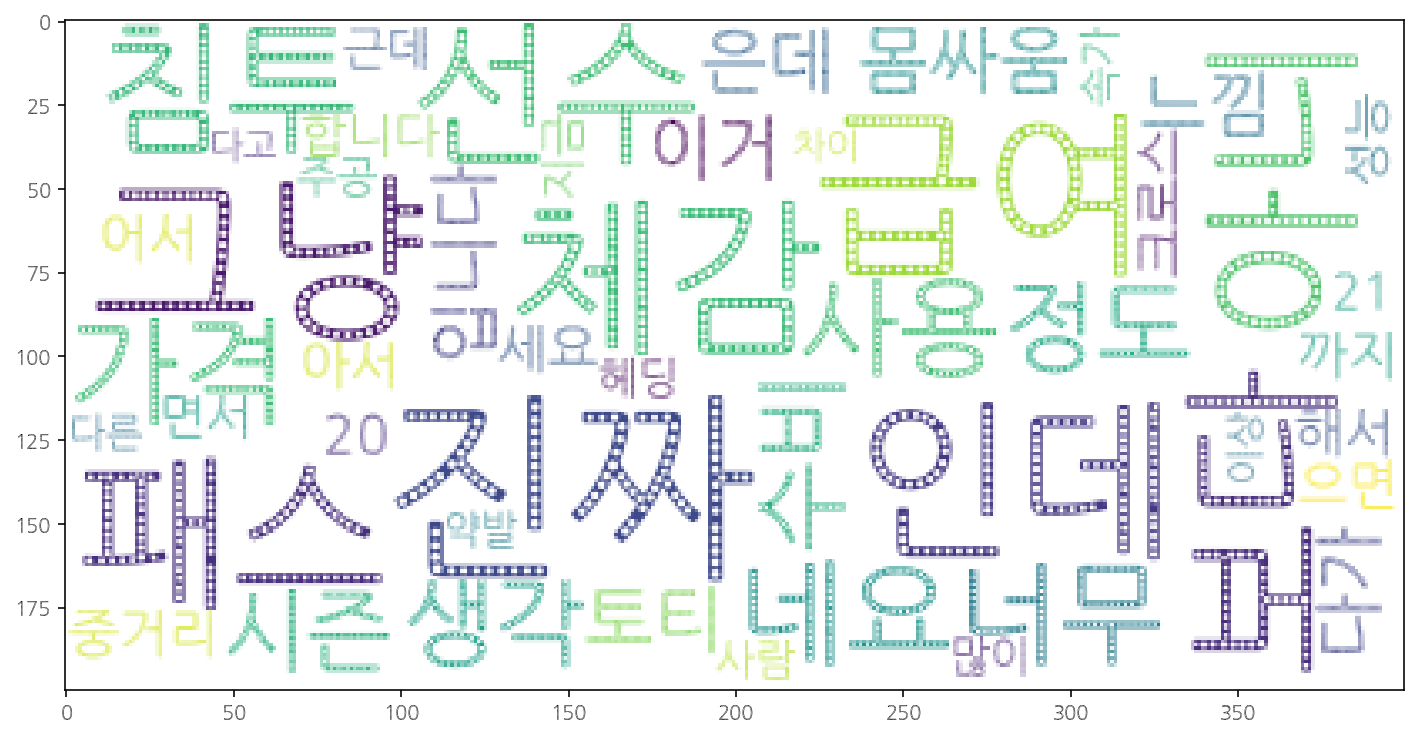

In [123]:
#부정 word_cloud
draw_wc(negative_words)

[('패스', 13086), ('체감', 12470), ('진짜', 12313), ('보다', 11553), ('침투', 10948), ('선수', 10938), ('아서', 9875), ('정도', 9626), ('몸싸움', 9610), ('사용', 9594)]


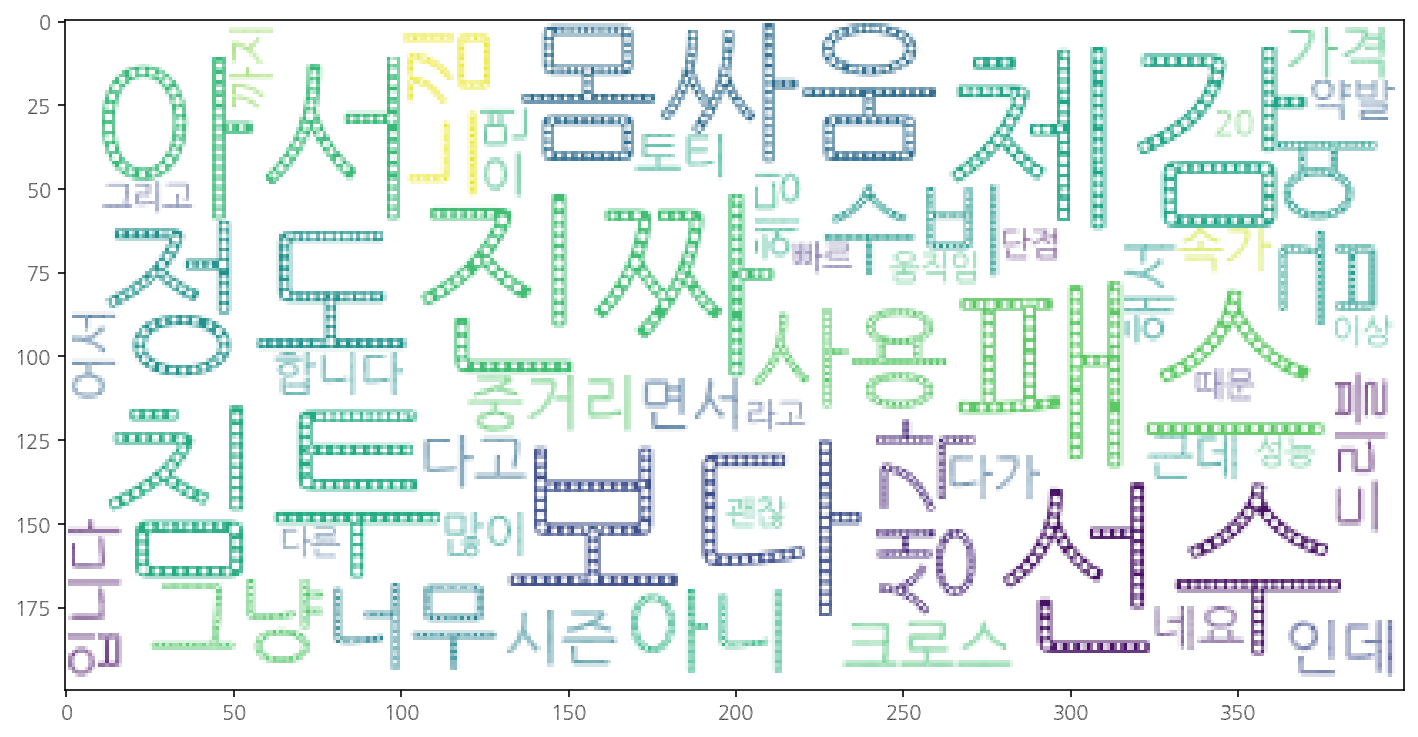

In [124]:
#긍정 word_cloud
draw_wc(positive_words)

[('침투', 14884), ('진짜', 10632), ('체감', 9232), ('그냥', 8191), ('보다', 8061), ('선수', 7437), ('몸싸움', 7281), ('토티', 7209), ('아니', 6983), ('정도', 6715)]


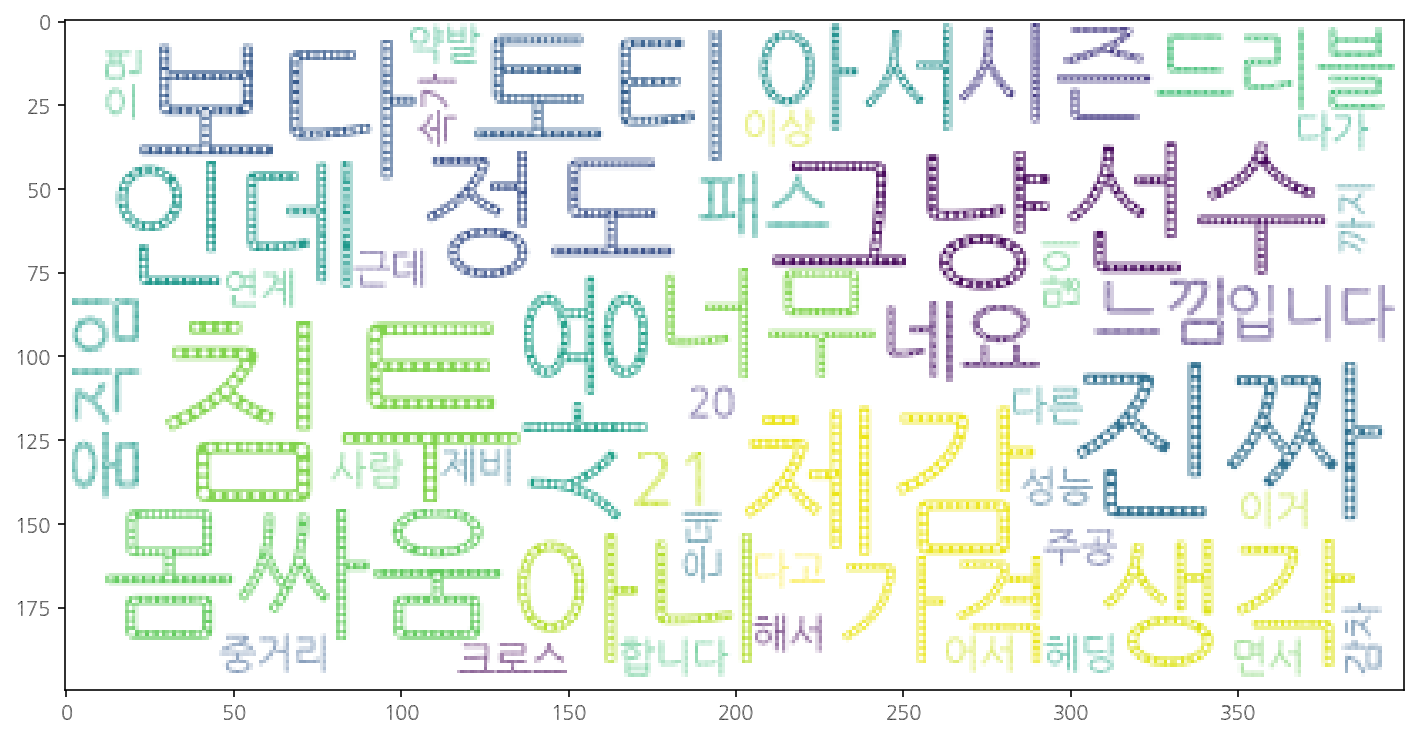

In [126]:
#fw word_cloud
draw_wc(fw_words)

[('패스', 15332), ('체감', 10395), ('진짜', 10115), ('중거리', 8041), ('보다', 7799), ('선수', 7734), ('급여', 7263), ('그냥', 6928), ('정도', 6604), ('사용', 6575)]


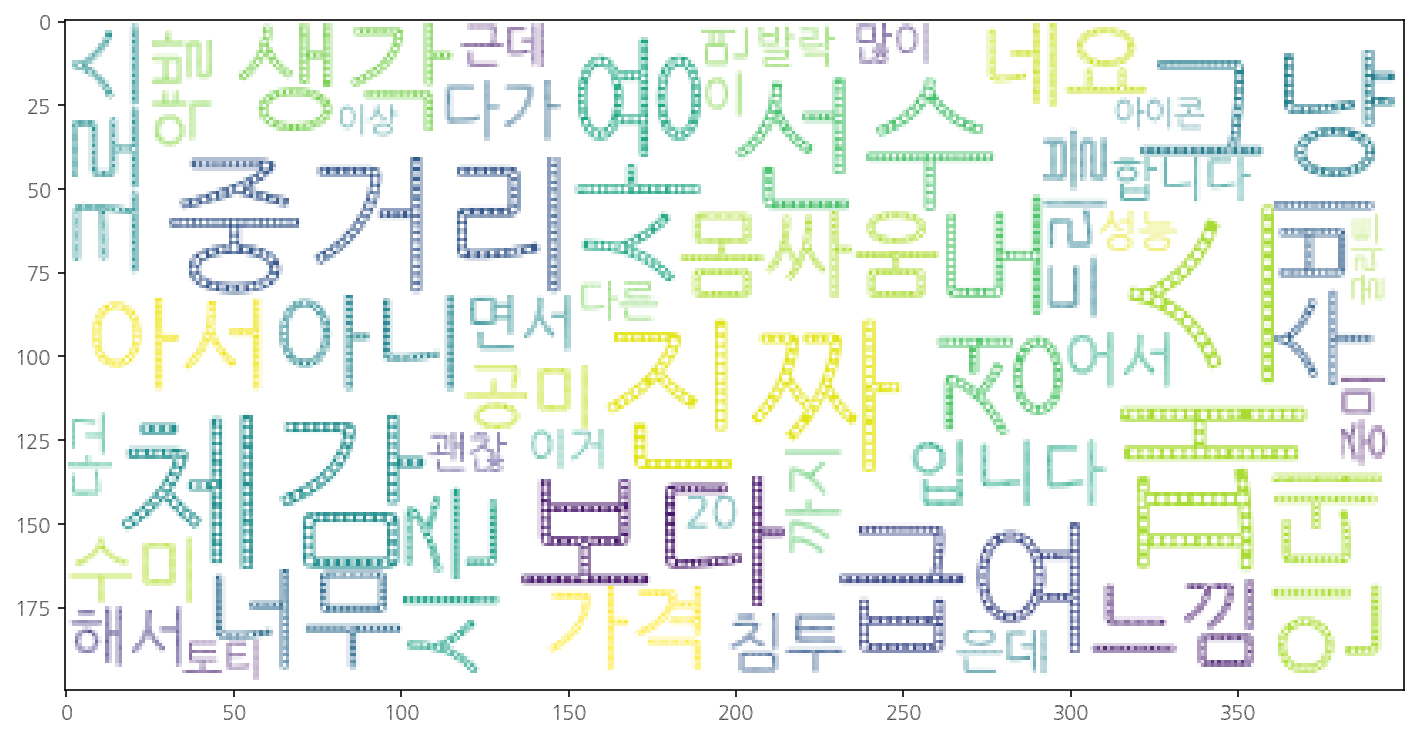

In [127]:
#mf word_cloud
draw_wc(mf_words)

[('급여', 11361), ('수비', 9590), ('진짜', 8195), ('보다', 6009), ('사용', 5719), ('그냥', 5655), ('인데', 5362), ('선수', 5346), ('너무', 5206), ('정도', 5188)]


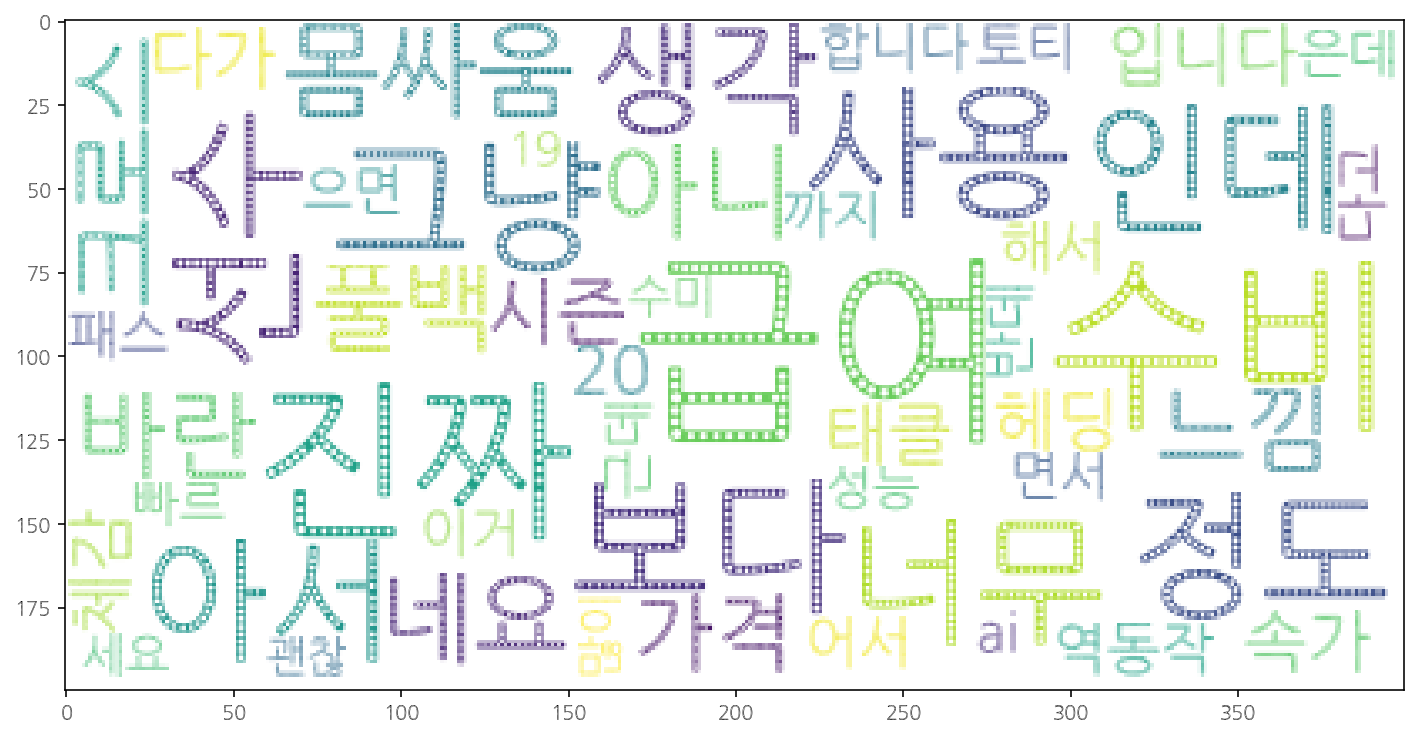

In [130]:
#df word_cloud
draw_wc(df_words)